In [ ]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
from tqdm import tqdm

import multiprocessing as mp


In [3]:
from simulation import leaf, QuadTree
from visualizer import renderParticles, drawTree

In [4]:
plt.ioff()

In [5]:

        
def quadAssign(p, node): 
    theta = np.arctan2(p[1] - node.center[1], p[0] - node.center[0]) * 180 / np.pi
    if theta < 90 and theta > 0: 
        node.ur = assignParticle(p, node.ur)
    elif theta < 180 and theta >= 90: 
        node.ul = assignParticle(p, node.ul)
    elif theta < 0 and theta >= -90:
        node.lr = assignParticle(p, node.lr)
    else: # theta < 360 and theta >= 270 
        node.ll = assignParticle(p, node.ll)
    return node
    
        
def assignParticle(p, node):
    # if a leaf has no particle, assign particle to leaf 
    if isinstance(node, leaf) and node.com is None:
        node.com = p
        node.mass = 1
    # if a leaf has a particle, make it a tree and re-assign particles
    elif isinstance(node, leaf) and node.com is not None: 
        p_old = node.com 
        node = QuadTree(node)
        node = assignParticle(p, node)  
        node = assignParticle(p_old, node)
        node.com = (p_old + p) / 2
        node.mass = 2
    # if tree, find out where in the tree the particle should live 
    else: 
        node = quadAssign(p, node)
        node.com = (node.com * node.mass + p) / (node.mass + 1)
        node.mass = node.mass + 1
        
    return node


In [6]:
# some constants ... 
L = 2
n = 10
m = 1
theta = 0 
softening = 0.01

<IPython.core.display.Javascript object>


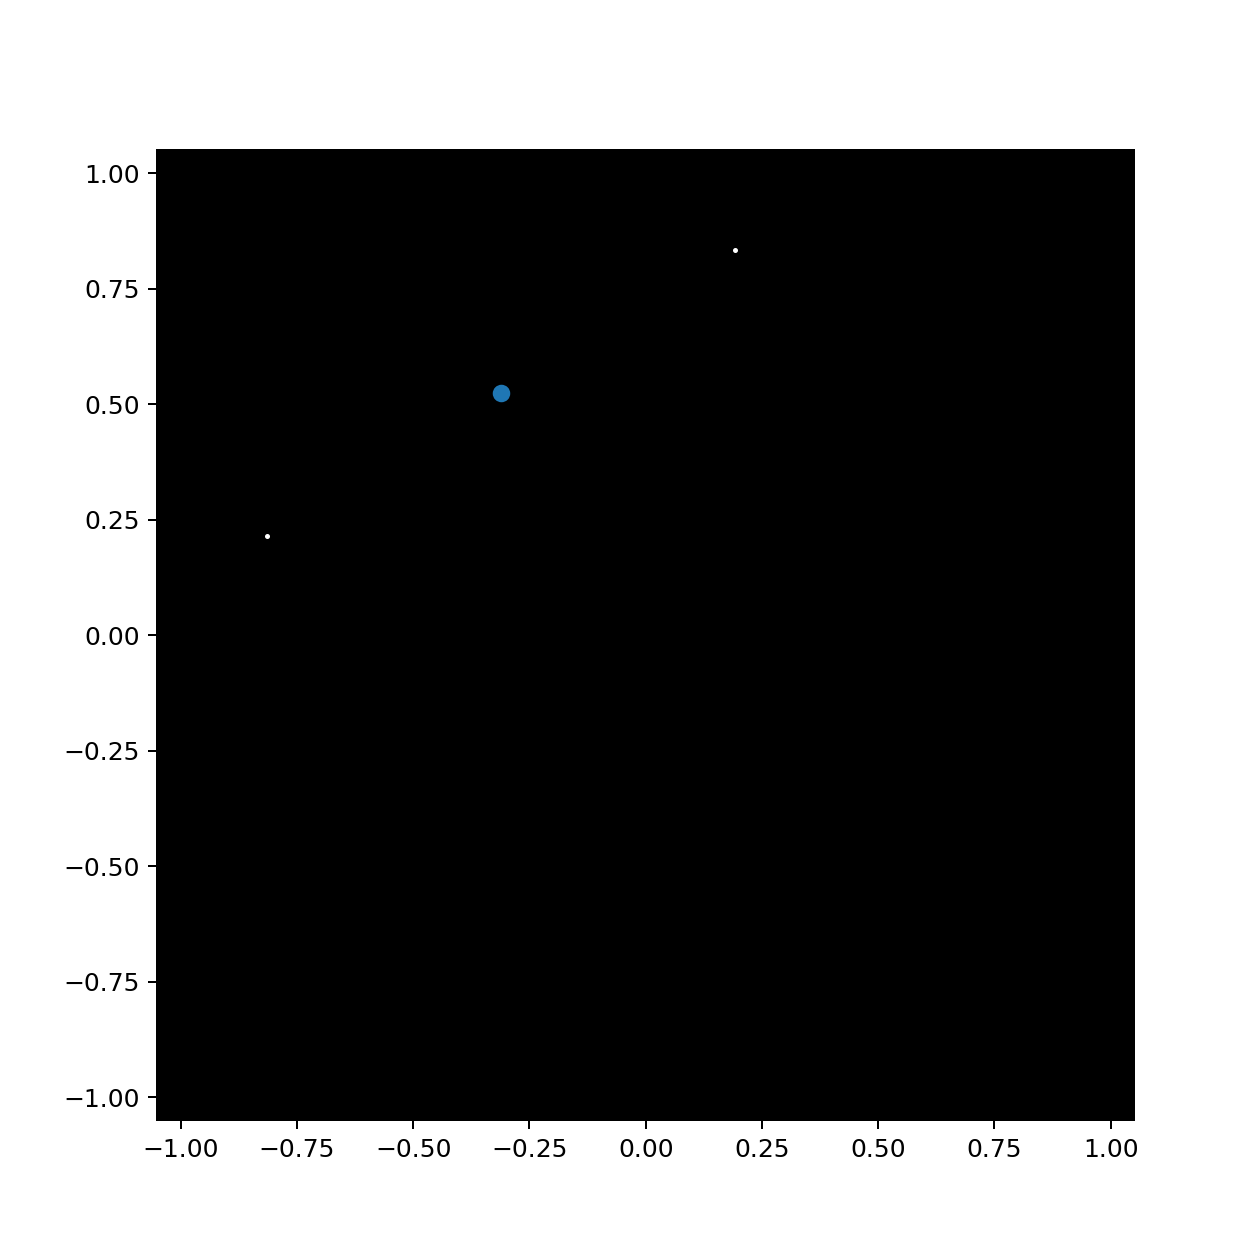

In [7]:
# random particles originally from (0, 1), scaled to (0, 2), shifted to (-1, 1)
n = 2
particles = np.random.random((n, 4)) * L - L / 2 
particles[:, 2] = 0 # np.random.random(n)
particles[:, 3] = 0 # np.random.random(n) - 0.5

fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.set_facecolor("black")
plt.scatter(particles[:, 0], particles[:, 1], s = 1, c='white')

plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)

# we start with a simple leaf (root) 
root = leaf()
# which we then can immediately turn into a tree 

for p in particles: 
    root = assignParticle(p[0:2], root)


plt.scatter(root.com[0], root.com[1])
# plt.scatter(root.ul.com[0], root.ul.com[1])
#plt.scatter(root.ll.com[0], root.ll.com[1])

# drawTree(ax, root)

plt.show()


In [8]:
particles

array([[ 0.1911789 ,  0.83375355,  0.        ,  0.        ],
       [-0.81531819,  0.21559929,  0.        ,  0.        ]])

In [9]:
(particles[1, 0:2] - particles[0, 0:2]) / (sum((particles[1, 0:2] - particles[0, 0:2])**2)**(0.5))**3

array([-0.61077416, -0.3751155 ])

In [10]:
(particles[0, 0:2] - particles[1, 0:2]) / sum((particles[0, 0:2] - particles[1, 0:2])**2)**(3 / 2)

array([0.61077416, 0.3751155 ])

In [11]:
# f_multipole(particles[0][0:2], root), f_multipole(particles[1][0:2], root)



In [12]:
(particles[1, 0:2] - particles[0, 0:2] ) / abs((particles[1, 0:2] - particles[0, 0:2] )**3)

array([-0.98713137, -2.61701526])

In [13]:
(particles[0, 0:2] - particles[1, 0:2]) 

array([1.00649709, 0.61815427])

In [14]:
# gravitational constant * (1 kpc / 3.086e+19 m)^2 * (1 kg / 5.02785e-31 solar mass)^2
# 6.674e-11 * (3.086e+19)**(-2) * (5.02785e-31)**(-2)
G = 6.674e-11  

In [30]:
def solve_acc(p, node, epsilon=0.0, G = 1e-3, m_scale=1, r_scale=1): 
    # do psudo periodic boundary conditions here 
    return G * m_scale * node.mass * (node.com - p + epsilon) / sum((node.com - p + epsilon)**2)**(3 / 2)

def f_multipole(p, node, theta=0.0):  
    # check to see if particle is looking at itself,return 0 
    if node.mass is not None and sum((node.com - p)**2)**0.5 < 1e-10:
        return np.zeros(2) 
    
    # if a leaf node and has a particle, directly solve for gravity 
    if isinstance(node, leaf) and node.mass is not None:
        return solve_acc(p, node)
    # if a leaf node and doesn't have a particle, return 0
    elif isinstance(node, leaf) and node.mass is None:
        return np.zeros(2)
    
    # if a quadtree that satisfies multipole condition, solve for gravity
    if isinstance(node, QuadTree) and node.length / sum((node.com - p)**2)**0.5 <= theta: 
        return solve_acc(p, node)
    # else if quadtree and hasn't satisfied, recursively search the tree's children 
    elif isinstance(node, QuadTree) and node.length / sum((node.com - p)**2)**0.5 > theta: 
        return sum(np.array([f_multipole(p, ch, theta) for ch in [node.ll, node.ur, node.lr, node.ul]]))
        


In [31]:
# f_multipole(particles[0][0:2], root, 0)

In [32]:
def leapfrog(r, t_start=0, t_end=10, N=1e4, L=2):
    dt = 0.01 # (t_end - t_start)/N

    tpoints = np.arange(t_start, t_end, dt)
    xpoints = []
    trees = []
    
    acc = np.zeros((len(r), 2))
    pos = r[:, 0:2]
    vel = r[:, 2: ]

    for t in tqdm(tpoints):
        # have to .copy() because we are updating the same array and that causes memory issues 
        xpoints.append(np.hstack((pos, vel, acc)))
        
        # use current acceleration to kick velocity a half time step
        vel = vel + acc * dt / 2 
        # drift the position using the kicked (half time step) velocity 
        pos = pos + vel * dt 
        
        # update acceleration block. construct the quadtree for force modeling 
        root = leaf()
        # which we then can immediately turn into a tree 
        for p in pos: 
            root = assignParticle(p, root)
        # calculate acceleration 
        acc = np.array([f_multipole(p, root, 0) for p in pos])
        
        # kick velocity a half time step using new updated acceleration  
        vel = vel + acc * dt / 2 
        
        # fix positions based on boundary conditions 
        pos[pos[:, 0] > L/2, 0] = pos[pos[:, 0] > L/2, 0] - L
        pos[pos[:, 0] < -L/2, 0] = pos[pos[:, 0] < -L/2, 0] + L
        pos[pos[:, 1] > L/2, 1] = pos[pos[:, 1] > L/2, 1] - L
        pos[pos[:, 1] < -L/2, 1] = pos[pos[:, 1] < -L/2, 1] + L
        
        trees.append(root)

        
    return tpoints, np.array(xpoints), np.array(trees)

In [33]:
# random particles originally from (0, 1), scaled to (0, 2), shifted to (-1, 1)
n = 2
particles = np.random.random((n, 4)) * 0.5 - 0.5 / 2 # L - L / 2 
particles[:, 2] = 0 # np.random.random(n)
particles[:, 3] = 0 # np.random.random(n) - 0.5
# particles = np.array([[0.15, 0, 0, 0], [-0.15, -0, 0, 0]])

tpoints, particles_list, trees = leapfrog(particles.copy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8226.04it/s]


In [34]:
import time 
from natsort import natsorted
import moviepy.video.io.ImageSequenceClip

tstart = time.time() 

print('[{:.2f}] Creating plot directory ...'.format(time.time() - tstart))
new_dir = '{}/{}'.format(os.path.abspath(os.getcwd()), 'L{}n{}'.format(L, n))
if not os.path.isdir(new_dir):
    os.mkdir(os.path.join(new_dir))

print('[{:.2f}] Initializing multiprocessing ...'.format(time.time() - tstart))
n_cpu = mp.cpu_count()
pool = mp.Pool(processes=n_cpu)

mp_trees = np.array_split(trees, n_cpu)
mp_particles = np.array_split(particles_list, n_cpu)
mp_tpoints = np.array_split(np.arange(len(tpoints)), n_cpu)
    
print('[{:.2f}] Creating plots ...'.format(time.time() - tstart))
for i in range(n_cpu):
    pool.apply_async(renderParticles, args=(mp_particles[i], mp_trees[i], mp_tpoints[i], new_dir))

pool.close()
pool.join()
print('[{:.2f}] Multiprocess concluded ...'.format(time.time() - tstart))


print('[{:.2f}] Creating video ...'.format(time.time() - tstart))

fps=30 #number of frames per second
image_files = natsorted([os.path.join(new_dir,img) for img in os.listdir(new_dir) if img.endswith(".png")], reverse=False)
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('test.mp4')

print('[{:.2f}] Video created ...'.format(time.time() - tstart))

_ = [os.remove(image_file) for image_file in image_files]
print('[{:.2f}] Directory cleaned ...'.format(time.time() - tstart))


[0.00] Creating plot directory ...
[0.00] Initializing multiprocessing ...
[0.07] Creating plots ...
[52.57] Multiprocess concluded ...
[52.57] Creating video ...
Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
[86.72] Video created ...
[86.75] Directory cleaned ...


In [41]:
root.ur.com

array([0.1911789 , 0.83375355])